<a href="https://colab.research.google.com/github/mloyorev/Theory/blob/main/9_OptimalSavingsJax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quantecon
import quantecon as qe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 2.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import quantecon as qe
import jax
import jax.numpy as jnp
from collections import namedtuple
import matplotlib.pyplot as plt

One difference between `numpy` and `jax` is that, when running on a GPU, `jax` uses 32 bit floats by default.  This is standard for GPU computing and can lead to significant speed gains with small loss of precision.

However, **for some calculations precision matters**. In this case we will use 64 bit floats with `jax`  in order to match with `7_OptimalSavingsNumba.ipynb` (this is because `numpy` use double precision floating point numbers, also known as `float64`).

In [3]:
jax.config.update("jax_enable_x64", True)

As in the previuous notebooks, we will define the following functions:


*   `supremum_norm`
*   `succesive_approx`



In [4]:
def supremum_norm(x,x_new):
  return np.max(jnp.abs(x_new - x))

def successive_approx(T,
                      x_0,
                      M,
                      tolerance=1e-6,
                      max_iter=10_000,
                      print_step=25,
                      verbose=False):

    x = x_0
    error = tolerance + 1
    k = 1

    while error > tolerance and k <= max_iter:
        x_new = T(x)
        error = M(x, x_new)
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1

    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")

    elif verbose:
        print(f"Terminated successfully in {k} iterations.")
    return x

# **Optimal savings model with Google Jax**

As we have alredy mentioned, the **Bellman equation** of this model is given by

$$V(w,y)=\max_{w'}u(Rw+y-w')+\beta\sum_{y'\in Y}V(w',y')Q(y',y)$$

where

$$u(c)=\frac{c^{1+\gamma}}{1+\gamma}$$

**Details on the model assumptions and detailed derivation of the Bellman equation** comes in the `7_OptimalSavingsNumba` notebook.

The main objetive of this notebook is to prove **how `jax` improve the performance** of the model solvers that we create in `7_OptimalSavingsNumba`

In [5]:
Model = namedtuple('Model',('beta', 'R', 'gamma', 'w_grid', 'y_grid', 'Q'))

def create_consumption_model(R=1.01,                    # Gross interest rate
                             beta=0.98,                 # Discount factor
                             gamma=2.5,                 # CRRA parameter
                             w_min=0.01,                # Min wealth
                             w_max=5.0,                 # Max wealth
                             w_size=150,                # Grid side
                             rho=0.9,                   # Persistance of the shock
                             nu=0.1,                    # Volatility of stochastic error (sigma)
                             y_size=100):

    w_grid = np.linspace(w_min, w_max, w_size)
    mc = qe.tauchen(rho= rho, sigma = nu, n = y_size)
    y_grid, Q = np.exp(mc.state_values), mc.P
    return Model(beta=beta, R=R, gamma=gamma, w_grid=w_grid, y_grid=y_grid, Q=Q)

In order to use `jax` **we have to create a `jax`-compatible version** of the consumption model.

This `jax`-compatible version of the consumption model:


*  Break up parameters into static and nonstatic components
*   Move the arrays to a device, for example the GPU or the TPU.

Moving the arrays to a device is very **important because:**


1.   GPUs (Graphics Processing Unit) and TPUs (Tensor Processing Unit) are designed to **perform parallel calculations** much faster than CPUs (Central Processing Unit).
2.   By moving data to the device, JAX is allowed to perform **parallel calculations** on specialized hardware, which can significantly speed up calculation performance and efficiency.





In [6]:
# Build a JAX-compatible version of the consumption model
def create_consumption_model_jax():

    model = create_consumption_model()          # Create an instance of the model
    beta, R, gamma, w_grid, y_grid, Q = model   # Unpacked model parameters

    # Break up parameters into static and nonstatic components
    constants = beta, R, gamma
    sizes = len(w_grid), len(y_grid)
    arrays = w_grid, y_grid, Q

    arrays = tuple(map(jax.device_put, arrays)) # Shift arrays to the device (e.g., GPU and TPU)

    return constants, sizes, arrays

Now we compute the RHS of the **Bellman equation**.

In [7]:
def B(v, constants, sizes, arrays):

    # Unpack model parameters
    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    # Notice that index:
    #   - i is for current wealth
    #   - j is for current income
    #   - ip is for next period's wealth
    #   - jp is for next period's income

    # Compute current rewards r(w, y, wp) as an array r[i, j, ip] of three dimesions
    w  = jnp.reshape(w_grid, (w_size, 1, 1))    # w[i]   ->  w[i, j, ip]
    y  = jnp.reshape(y_grid, (1, y_size, 1))    # z[j]   ->  z[i, j, ip]
    wp = jnp.reshape(w_grid, (1, 1, w_size))    # wp[ip] -> wp[i, j, ip]
    c = R * w + y - wp                          # Current reward

    # Calculate continuation rewards at all combinations of (w, y, wp)
    v = jnp.reshape(v, (1, 1, w_size, y_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Q = jnp.reshape(Q, (1, y_size, 1, y_size))  # Q[j, jp]  -> Q[i, j, ip, jp]
    EV = jnp.sum(v * Q, axis=3)                 # Sum over last index jp for the expected value

    # Comoute the RHS of the Bellman equation if and only if c>0, otherwise set -np.inf
    return jnp.where(c > 0, c**(1-γ)/(1-γ) + β * EV, -np.inf)

First of all we need to ***prove that our Bellman equation satisfies the Blackwell's sufficiency conditions*** to be a contraction mapping .

For a detailed demonstration of Blackwell's sufficiency conditions for this case, check the `7_OptimalSavingsNumba.ipynb` notebook.

As in the previous notebooks, we are going to use the **following algorithms** to solve the model:



*   Value Function Iteration (VFI).
*   Howard Policy Ieration (HPI).
*   Optimistic Policy Iteration (OPI).



Now we **define the necessary operators** for creating the solvers of the model:


*   **`COMPUTE CURRENT REWARD`:** Compute the array $r_\sigma(w, y) = r(w,y, σ(w, y))$, which gives current rewards given policy sigma.
*   **`BELLMAN OPERATOR`:** Compute the maximization of the Bellman equation along next period's wealth.
*   **`GET GREEDY`:** Compute the index of the argument that maximizr the Bellman equation along the next period's wealth.
*   **`POLICY OPERATOR`:** Compute the value associated with a particular policy.




In [8]:
# -----COMPUTE CURRENT REWARD-----
def compute_r_sigma(sigma, constants, sizes, arrays):
  # Unpack model
    beta, R, gamma = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

  # Compute r_σ[i, j]
    w = jnp.reshape(w_grid, (w_size, 1))  # w[i]   ->  w[i, j]
    y = jnp.reshape(y_grid, (1, y_size))  # y[j]   ->  y[i, j]
    wp = w_grid[sigma]                    # Selection of values ​​from a grid w_grid using indices contained in an array called sigma.
    c = R * w + y - wp                    # Compute consumption
    r_sigma = c**(1-gamma)/(1-gamma)      # Compute current reward

    return r_sigma

# -----BELLMAN OPERATOR-----
def T(v, constants, sizes, arrays):
    return jnp.max(B(v, constants, sizes, arrays), axis=2)  #   The result of the B function is passed through the jnp.max function with axis=2. This means that
                                                            # the maximum value is computed along the third axis, which corresponds to the 'wp' axis. This operation
                                                            # calculates the maximum value for each combination of (w,y). The result of the T function is a 2D matrix

# -----GET GREEDY-----
def get_greedy(v, constants, sizes, arrays):
    return jnp.argmax(B(v, constants, sizes, arrays), axis=2) #   The result of the B function is then passed through the jnp.argmax function with axis=2. This means that the index
                                                              # of the maximum value is computed along the third axis, which corresponds to the 'wp' axis. This operation finds the
                                                              # index of the action that maximizes RHS of the Bellman equation for each combination (w,y).

# -----POLICY OPERATOR-----
def T_sigma(v, sigma, constants, sizes, arrays):
    # Unpack model
    beta, R, gamma = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    r_sigma = compute_r_sigma(sigma, constants, sizes, arrays)  # Compute current reward

    # Compute the array v[σ[i, j], jp]
    yp_idx = jnp.arange(y_size)
    yp_idx = jnp.reshape(yp_idx, (1, 1, y_size))
    sigma = jnp.reshape(sigma, (w_size, y_size, 1))
    V = v[sigma, yp_idx]

    # Convert Q[j, jp] to Q[i, j, jp]
    Q = jnp.reshape(Q, (1, y_size, y_size))

    return r_sigma + beta * np.sum(V * Q, axis=2)

The functions below **compute the value $v_{\sigma}$ of following a policy $\sigma$**.

This lifetime value is a function $v_{\sigma}$ that satisifies

$$v_{\sigma}(w,y)=r_{\sigma}(w,y)+\beta\sum_{y'}v_{\sigma}(\sigma(w,y),y')Q(y',y)$$

where we want to solve for $v_{\sigma}$.

Suppose we define the linear operator $L_{\sigma}$ by

$$(L_{\sigma}v)(w,y)=v(w,y)-\beta\sum_{y'}v_(\sigma(w,y),y')Q(y',y)$$

With this notation, the objective is to solve for $v$ via

$$(L_{\sigma}v)(w,y)=r_{\sigma}(w,y)$$

which in vector notation is $L_{\sigma}v=r_{\sigma}$. The vector notation of the problem implies that

$$v=L_{\sigma}^{-1}r_{\sigma}$$

`jax` allows us to solve linear systes defined in terms of operators. The first step is to define the function $L_{\sigma}$.

In [9]:
def L_sigma(v, sigma, constants, sizes, arrays):
    # Unpack model
    beta, R, gamma = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    # Set up the array v[σ[i, j], jp]
    zp_idx = jnp.arange(y_size)                     # Create one-dimensional arrays ranging from 0 to y_size-1
    zp_idx = jnp.reshape(zp_idx, (1, 1, y_size))    # Reshape zp_idx as an array of three dimensiones (i,j,ip)
    sigma = jnp.reshape(sigma, (w_size, y_size, 1)) # Reshape sigma as an array of three dimensiones (i,j,ip)
    V = v[sigma, zp_idx]                            # Evaluate v(w',y')

    # Expand Q[j, jp] to Q[i, j, jp]
    Q = jnp.reshape(Q, (1, y_size, y_size))

    # Compute and return v[i, j] - β Σ_jp v[σ[i, j], jp] * Q[j, jp]
    return v - beta * np.sum(V * Q, axis=2)

Now we can define a function that computes $v_{\sigma}$ with the help of the previous function.

In [10]:
def get_value(sigma, constants, sizes, arrays):
    # Unpack
    beta, R, gamma = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    r_sigma = compute_r_sigma(sigma, constants, sizes, arrays)               # Computes current reward

    # Reduce R_σ to a function in v
    partial_R_sigma = lambda v: L_sigma(v, sigma, constants, sizes, arrays)  # Defines a function 'partial_R_sigma' that takes v as an argument

    return jax.scipy.sparse.linalg.bicgstab(partial_R_sigma, r_sigma)[0] #  Uses the BiCGSTAB iterative method to solve a system of linear equations of the form
                                                                         # (partial_R_sigma)x = r_sigma.BiCGSTAB is an iterative method that, in each iteration,
                                                                         #  calculates an approximation to the solution x of the system of equations.

Below are the **JIT compiled versions** of the operators. A JIT compiled version refers to a version of a program that has been compiled using a technique called just-in-time (JIT) compilation.


In this case the functions defined earlier are compiled using `jax.jit` and checking `static_argnums`. Where `static_argnums` indicates the function argument that remains static, particularly.

In [11]:
# The static argument is 'sizes'
B = jax.jit(B, static_argnums=(2,))
compute_u_σ = jax.jit(compute_r_sigma, static_argnums=(2,))
T = jax.jit(T, static_argnums=(2,))
get_greedy = jax.jit(get_greedy, static_argnums=(2,))
get_value = jax.jit(get_value, static_argnums=(2,))

# The static argument is 'sizes'
T_sigma = jax.jit(T_sigma, static_argnums=(3,))
L_sigma = jax.jit(L_sigma, static_argnums=(3,))

Now we **define the solvers**, which implement VFI, HPI and OPI (We have already explain how does this algorithms works in `7_OptimalSavingsNumba.ipynb` and `8_InvestmentAdjustmentCostsNumba.ipynb`).

In [29]:
def value_iteration(model, tol=1e-5):
    constants, sizes, arrays = model
    vz = jnp.zeros(sizes)

    v_star = successive_approx(lambda v: T(v, constants, sizes, arrays), vz, supremum_norm,tolerance=tol)
    return get_greedy(v_star, constants, sizes, arrays)

In [17]:
# Howard Policy Iteration
def policy_iteration(model, maxiter=250):
    constants, sizes, arrays = model
    sigma = jnp.zeros(sizes, dtype=int)
    i, error = 0, 1.0
    while error > 0 and i < maxiter:
        v_sigma = get_value(sigma, constants, sizes, arrays)
        sigma_new = get_greedy(v_sigma, constants, sizes, arrays)
        error = jnp.max(jnp.abs(sigma_new - sigma))
        sigma = sigma_new
        i = i + 1
        print(f"Concluded loop {i} with error {error}.")
    return sigma

In [37]:
# Optimistic Policy Iteration
def optimistic_policy_iteration(model, tol=1e-5, m=10):
    constants, sizes, arrays = model
    v = jnp.zeros(sizes)
    error = tol + 1
    while error > tol:
        last_v = v
        sigma = get_greedy(v, constants, sizes, arrays)
        for _ in range(m):
            v = T_sigma(v, sigma, constants, sizes, arrays)
        error = jnp.max(jnp.abs(v - last_v))
    return get_greedy(v, constants, sizes, arrays)

Here's a quick test of the **timing** of each solver.

In [19]:
model = create_consumption_model_jax()

In [32]:
# Value Function Iteration
print("Starting VFI.")
qe.tic()
out = value_iteration(model)
elapsed = qe.toc()
print(out)
print(f"VFI completed in {elapsed} seconds.")

Starting VFI.
TOC: Elapsed: 0:00:38.77
[[  0   0   0 ...  20  21  22]
 [  0   0   0 ...  21  22  23]
 [  0   0   0 ...  22  23  24]
 ...
 [133 133 133 ... 149 149 149]
 [134 134 134 ... 149 149 149]
 [135 135 135 ... 149 149 149]]
VFI completed in 38.77844786643982 seconds.


In [33]:
# Howard Policy Iteration
print("Starting HPI.")
qe.tic()
out = policy_iteration(model)
elapsed = qe.toc()
print(out)
print(f"HPI completed in {elapsed} seconds.")

Starting HPI.
Concluded loop 1 with error 77.
Concluded loop 2 with error 55.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 8.
Concluded loop 6 with error 4.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 0.
TOC: Elapsed: 0:00:2.57
[[  0   0   0 ...  20  21  22]
 [  0   0   0 ...  21  22  23]
 [  0   0   0 ...  22  23  24]
 ...
 [133 133 133 ... 149 149 149]
 [134 134 134 ... 149 149 149]
 [135 135 135 ... 149 149 149]]
HPI completed in 2.5735397338867188 seconds.


In [39]:
# Optimistic Policy Iteration
print("Starting OPI.")
qe.tic()
out = optimistic_policy_iteration(model, m=100)
elapsed = qe.toc()
print(out)
print(f"OPI completed in {elapsed} seconds.")

Starting OPI.
TOC: Elapsed: 0:00:4.29
[[  0   0   0 ...  20  21  22]
 [  0   0   0 ...  21  22  23]
 [  0   0   0 ...  22  23  24]
 ...
 [133 133 133 ... 149 149 149]
 [134 134 134 ... 149 149 149]
 [135 135 135 ... 149 149 149]]
OPI completed in 4.2918126583099365 seconds.


Finally we repeat the exersice in `7_OptimalSavingsNumba.ipynb`, in which we compare the relation between the three algorithms (VFI, HPI, OPI) for different step size $m$ in the opi algorithm.

Running Howard policy iteration.
Concluded loop 1 with error 77.
Concluded loop 2 with error 55.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 8.
Concluded loop 6 with error 4.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 0.
TOC: Elapsed: 0:00:3.40
PI completed in 3.4099180698394775 seconds.
Running value function iteration.
TOC: Elapsed: 0:00:29.44
VFI completed in 29.44074583053589 seconds.
TOC: Elapsed: 0:00:10.71
OPI with m=5 completed in 10.717214822769165 seconds.
TOC: Elapsed: 0:00:2.96
OPI with m=45 completed in 2.9623992443084717 seconds.
TOC: Elapsed: 0:00:3.66
OPI with m=85 completed in 3.6693217754364014 seconds.
TOC: Elapsed: 0:00:4.43
OPI with m=125 completed in 4.436034679412842 seconds.
TOC: Elapsed: 0:00:4.91
OPI with m=165 completed in 4.917816400527954 seconds.
TOC: Elapsed: 0:00:6.68
OPI with m=205 completed in 6.687604188919067 seconds.
TOC: Elapsed: 0:00:7.02
OPI with m=245 

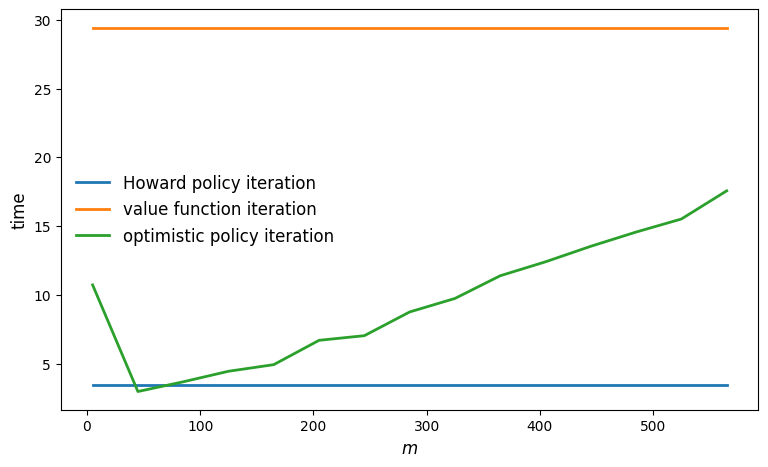

In [46]:
m_vals = range(5, 600, 40)
model = create_consumption_model_jax()
print("Running Howard policy iteration.")
qe.tic()
σ_pi = policy_iteration(model)
pi_time = qe.toc()
print(f"PI completed in {pi_time} seconds.")

print("Running value function iteration.")
qe.tic()
σ_vfi = value_iteration(model, tol=1e-5)
vfi_time = qe.toc()
print(f"VFI completed in {vfi_time} seconds.")

opi_times = []
for m in m_vals:
    qe.tic()
    σ_opi = optimistic_policy_iteration(model, m=m, tol=1e-5)
    opi_time = qe.toc()
    print(f"OPI with m={m} completed in {opi_time} seconds.")
    opi_times.append(opi_time)

fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(m_vals, np.full(len(m_vals), pi_time),
        lw=2, label="Howard policy iteration")
ax.plot(m_vals, np.full(len(m_vals), vfi_time),
        lw=2, label="value function iteration")
ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
ax.legend(fontsize=12, frameon=False)
ax.set_xlabel("$m$", fontsize=12)
ax.set_ylabel("time", fontsize=12)
plt.show()